
# PhysioNet Motor Imagery – Data Cleaning

This notebook consolidates quality metrics extracted during exploratory analysis and produces
a clean subject/run inventory. We recompute robust z-scores, flag problematic runs, and export
CSV artefacts that downstream notebooks can consume.



## Workflow
1. Load the cached run-level summary produced during EDA.
2. Recompute amplitude-based z-scores (excluding all-NaN columns such as `line_noise_ratio`).
3. Mark a run as *bad* if it violates any of the following heuristics:
   - `amp_issue_flag` raised during raw inspection.
   - `has_noisy_issue` flagged by the spectrum-based detector.
   - Clipping fraction above 5%.
   - Any amplitude-related z-score exceeds 3.0.
4. Aggregate per subject, keep only participants with at least 10 good runs **and**
   ≥70% of their sessions passing the filters.
5. Export `physionet_good_runs.csv` and `physionet_good_subjects.csv`.


In [4]:
print("hello world")

hello world


In [5]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

DATA_ROOT = Path('data/physionet')
DERIVED_DIR = DATA_ROOT / 'derived'
RUN_SUMMARY_PATH = DERIVED_DIR / 'physionet_run_summary.csv'
SUBJECT_SUMMARY_PATH = DERIVED_DIR / 'physionet_subject_summary.csv'

assert RUN_SUMMARY_PATH.exists(), f"Missing run summary: {RUN_SUMMARY_PATH.as_posix()}"
RUN_DF = pd.read_csv(RUN_SUMMARY_PATH)
print(f"Loaded {RUN_DF.shape[0]} runs from {RUN_SUMMARY_PATH}")
RUN_DF.head()

Loaded 1526 runs from data\physionet\derived\physionet_run_summary.csv


,subject,run,session,category,task,sfreq,n_channels,duration_s,mean_channel_std_uv,median_channel_std_uv,...,band_alpha_rel_power_std,band_beta_rel_power_mean,band_beta_rel_power_std,band_gamma_rel_power_mean,band_gamma_rel_power_std,has_flat_issue,has_noisy_issue,amp_issue_flag,max_abs_z,zscore_flag
0,S001,R01,baseline,resting_state,Baseline eyes open,160.0,64,60.99375,56.076575,52.452534,...,0.034929,0.125122,0.053379,0.020059,0.015120,False,False,True,NaN,False
1,S001,R02,baseline,resting_state,Baseline eyes closed,160.0,64,60.99375,52.817654,50.628951,...,0.135115,0.130307,0.039210,0.019399,0.016607,False,False,False,NaN,False
2,S001,R03,run_1,motor_execution,Open/close left fist (executed),160.0,64,124.99375,58.346287,52.637835,...,0.038692,0.127314,0.055687,0.021609,0.015709,False,True,True,NaN,False
3,S001,R04,run_1,motor_execution,Open/close right fist (executed),160.0,64,124.99375,52.817273,52.674999,...,0.031510,0.139725,0.050686,0.026578,0.018319,False,False,False,NaN,False
4,S001,R05,run_1,motor_execution,Open/close both fists (executed),160.0,64,124.99375,55.644805,51.973645,...,0.036560,0.133283,0.061212,0.027761,0.019522,False,False,False,NaN,False



## Recompute z-scores (amplitude- and power-based metrics)
`line_noise_ratio` is NaN for most runs, so we drop columns that do not contain useful variance.


In [6]:
from scipy.stats import zscore

numeric_cols = [
    'mean_channel_std_uv', 'median_channel_std_uv', 'p90_channel_std_uv',
    'max_channel_std_uv', 'p95_channel_ptp_uv', 'max_channel_ptp_uv',
    'clip_fraction_over_200uv', 'max_abs_signal_uv',
    'band_alpha_rel_power_mean', 'band_beta_rel_power_mean', 
    'band_theta_rel_power_mean', 'band_delta_rel_power_mean', 'band_gamma_rel_power_mean'
]

available_cols = [
    col for col in numeric_cols
    if col in RUN_DF.columns and RUN_DF[col].notna().any() and RUN_DF[col].std(ddof=0) > 0
]

print(f"Available numeric columns for z-score computation: {len(available_cols)}")
print(available_cols[:5])

z_df = RUN_DF[available_cols].copy()
z_scores = pd.DataFrame(
    zscore(z_df.values, axis=0, nan_policy='omit'),
    columns=available_cols,
    index=RUN_DF.index
)

RUN_DF['max_abs_z'] = z_scores.abs().max(axis=1)
RUN_DF['max_abs_z'] = RUN_DF['max_abs_z'].fillna(0.0)

print(f"\nZ-score statistics:")
RUN_DF['max_abs_z'].describe()

Available numeric columns for z-score computation: 13
['mean_channel_std_uv', 'median_channel_std_uv', 'p90_channel_std_uv', 'max_channel_std_uv', 'p95_channel_ptp_uv']

Z-score statistics:


count    1526.000000
mean        1.718554
std         0.992105
min         0.445067
25%         1.085088
50%         1.447290
75%         1.974739
max         8.821419
Name: max_abs_z, dtype: float64


## Run-level exclusion logic


In [7]:
CLIP_THRESHOLD = 0.05
Z_THRESHOLD = 3.0
FLAT_CHANNEL_THRESHOLD = 2
MIN_STD_UV = 2.0
MAX_STD_UV = 75.0

RUN_DF['has_flat_issue'] = RUN_DF['flat_channel_count'] > FLAT_CHANNEL_THRESHOLD
RUN_DF['has_noisy_issue'] = RUN_DF['noisy_channel_count'] > 0
RUN_DF['amp_issue_flag'] = (
    RUN_DF['has_flat_issue'] |
    RUN_DF['has_noisy_issue'] |
    (RUN_DF['mean_channel_std_uv'] < MIN_STD_UV) |
    (RUN_DF['mean_channel_std_uv'] > MAX_STD_UV) |
    (RUN_DF['clip_fraction_over_200uv'] > CLIP_THRESHOLD)
)

RUN_DF['bad_run'] = (
    RUN_DF['amp_issue_flag']
    | (RUN_DF['clip_fraction_over_200uv'] > CLIP_THRESHOLD)
    | (RUN_DF['max_abs_z'] > Z_THRESHOLD)
)

RUN_DF['quality_label'] = np.where(RUN_DF['bad_run'], 'exclude', 'keep')

quality_counts = RUN_DF['quality_label'].value_counts().rename_axis('label').reset_index(name='count')
print(f"\nData quality summary:")
print(quality_counts)
print(f"\nBad runs breakdown:")
print(f"  - Amplitude issues: {RUN_DF['amp_issue_flag'].sum()}")
print(f"  - High clipping: {(RUN_DF['clip_fraction_over_200uv'] > CLIP_THRESHOLD).sum()}")
print(f"  - Z-score outliers: {(RUN_DF['max_abs_z'] > Z_THRESHOLD).sum()}")

quality_counts


Data quality summary:
     label  count
0     keep    790
1  exclude    736

Bad runs breakdown:
  - Amplitude issues: 663
  - High clipping: 288
  - Z-score outliers: 136


,label,count
0,keep,790
1,exclude,736


C:\Users\Sujal Bhatu\AppData\Local\Temp\ipykernel_15156\4018318422.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=quality_counts, x='label', y='count', palette=['#2ca02c', '#d62728'])


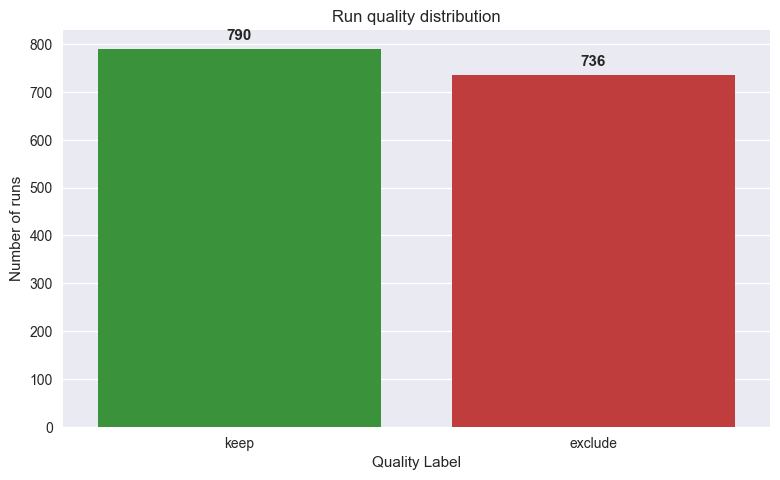

In [8]:
plt.figure(figsize=(8, 5))
sns.barplot(data=quality_counts, x='label', y='count', palette=['#2ca02c', '#d62728'])
plt.title('Run quality distribution')
plt.ylabel('Number of runs')
plt.xlabel('Quality Label')
for i, row in quality_counts.iterrows():
    plt.text(i, row['count'] + 20, f"{row['count']}", ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()


## Subject-level aggregation


In [9]:
MIN_GOOD_RUNS = 10
MIN_GOOD_RATIO = 0.70

subject_quality = (
    RUN_DF.groupby('subject')
          .agg(
              total_runs=('run', 'count'),
              bad_runs=('bad_run', 'sum'),
              avg_clip_fraction=('clip_fraction_over_200uv', 'mean'),
              max_clip_fraction=('clip_fraction_over_200uv', 'max'),
              median_std_uv=('mean_channel_std_uv', 'median'),
              min_std_uv=('mean_channel_std_uv', 'min'),
              max_std_uv=('mean_channel_std_uv', 'max'),
              flat_runs=('has_flat_issue', 'sum'),
              noisy_runs=('has_noisy_issue', 'sum'),
              total_events=('events_total', 'sum'),
              total_label_1=('events_label_1', 'sum'),
              total_label_2=('events_label_2', 'sum')
          )
          .assign(
              good_runs=lambda df: df['total_runs'] - df['bad_runs'],
              good_ratio=lambda df: df['good_runs'] / df['total_runs']
          )
)

subject_quality['is_good_subject'] = (
    (subject_quality['good_runs'] >= MIN_GOOD_RUNS)
    & (subject_quality['good_ratio'] >= MIN_GOOD_RATIO)
)

print(f"\nSubject quality thresholds:")
print(f"  - Minimum good runs: {MIN_GOOD_RUNS}")
print(f"  - Minimum good ratio: {MIN_GOOD_RATIO}")
print(f"\nSubject statistics:")
print(f"  - Total subjects: {len(subject_quality)}")
print(f"  - Good subjects: {subject_quality['is_good_subject'].sum()}")
print(f"  - Bad subjects: {(~subject_quality['is_good_subject']).sum()}")

subject_quality.sort_values('good_ratio', ascending=False).head(10)


Subject quality thresholds:
  - Minimum good runs: 10
  - Minimum good ratio: 0.7

Subject statistics:
  - Total subjects: 109
  - Good subjects: 51
  - Bad subjects: 58


,total_runs,bad_runs,avg_clip_fraction,max_clip_fraction,median_std_uv,min_std_uv,max_std_uv,flat_runs,noisy_runs,total_events,total_label_1,total_label_2,good_runs,good_ratio,is_good_subject
subject,,,,,,,,,,,,,,,
S005,14,0,0.000951,0.002874,42.297888,39.221825,45.963372,0,0,362,89,91,14,1.0,True
S011,14,0,0.000526,0.001969,30.275800,26.373483,35.526355,0,0,362,89,91,14,1.0,True
S006,14,0,0.001038,0.001889,24.574304,17.360465,30.143773,0,0,362,90,90,14,1.0,True
S020,14,0,0.000093,0.001297,22.213841,17.047535,47.849476,0,0,362,88,92,14,1.0,True
S038,14,0,0.003130,0.012759,30.589816,29.470567,48.726766,0,0,362,92,88,14,1.0,True
S030,14,0,0.000772,0.010678,25.045487,19.759845,58.674286,0,0,362,92,88,14,1.0,True
S033,14,0,0.006085,0.010631,31.609807,23.304985,34.721158,0,0,362,87,93,14,1.0,True
S037,14,0,0.000045,0.000592,12.906979,11.547798,28.633399,0,0,362,90,90,14,1.0,True
S034,14,0,0.001115,0.015465,24.712665,19.147100,65.128870,0,0,362,88,92,14,1.0,True


C:\Users\Sujal Bhatu\AppData\Local\Temp\ipykernel_15156\2830987514.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_counts, x='is_good', y='subjects', palette=['#d62728', '#2ca02c'], ax=axes[0])


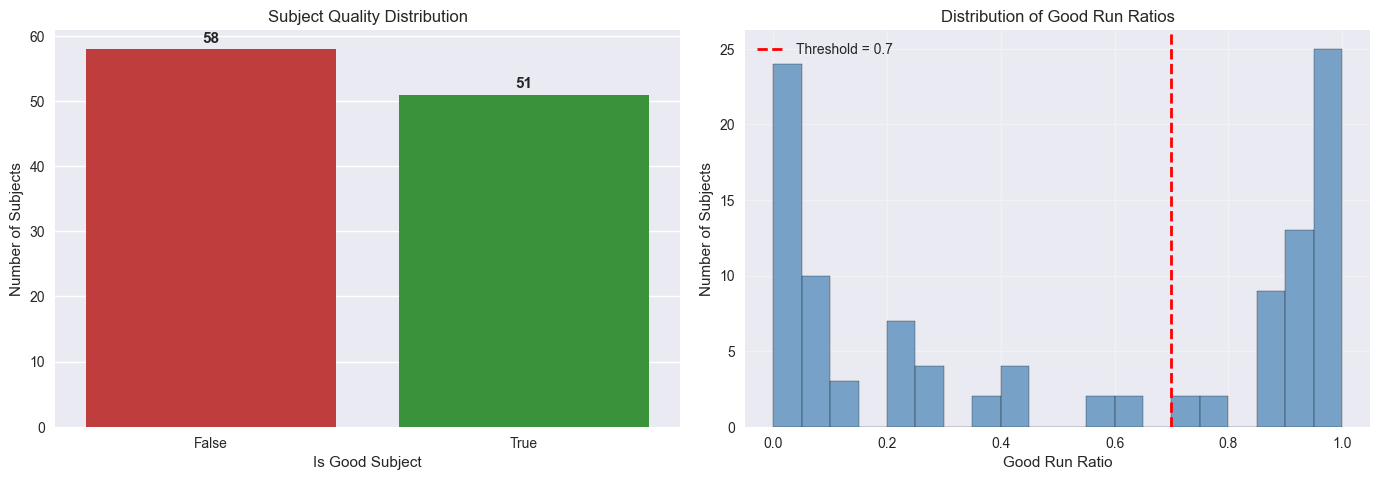

,is_good,subjects
0,False,58
1,True,51


In [10]:
summary_counts = subject_quality['is_good_subject'].value_counts().rename_axis('is_good').reset_index(name='subjects')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=summary_counts, x='is_good', y='subjects', palette=['#d62728', '#2ca02c'], ax=axes[0])
axes[0].set_title('Subject Quality Distribution')
axes[0].set_xlabel('Is Good Subject')
axes[0].set_ylabel('Number of Subjects')
for i, row in summary_counts.iterrows():
    axes[0].text(i, row['subjects'] + 1, f"{row['subjects']}", ha='center', fontsize=11, fontweight='bold')

axes[1].hist(subject_quality['good_ratio'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(MIN_GOOD_RATIO, color='red', linestyle='--', linewidth=2, label=f'Threshold = {MIN_GOOD_RATIO}')
axes[1].set_title('Distribution of Good Run Ratios')
axes[1].set_xlabel('Good Run Ratio')
axes[1].set_ylabel('Number of Subjects')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

summary_counts


## Filtered inventories


In [11]:
good_subjects = subject_quality[subject_quality['is_good_subject']].index.tolist()
good_runs_df = RUN_DF.loc[(~RUN_DF['bad_run']) & (RUN_DF['subject'].isin(good_subjects))].copy()

print(f"Retained {len(good_subjects)} subjects with at least {MIN_GOOD_RUNS} clean runs each.")
print(f"Retained {good_runs_df.shape[0]} runs across retained subjects.")
print(f"Total runs filtered out: {len(RUN_DF) - len(good_runs_df)}")
print(f"\nGood runs by category:")
print(good_runs_df.groupby('category')['run'].count())
print(f"\nEvent distribution in good runs:")
print(f"  - Total events: {good_runs_df['events_total'].sum()}")
print(f"  - Label 1 events: {good_runs_df['events_label_1'].sum()}")
print(f"  - Label 2 events: {good_runs_df['events_label_2'].sum()}")

good_runs_df[['subject', 'run', 'category', 'task', 'mean_channel_std_uv', 'clip_fraction_over_200uv']].head(10)

Retained 51 subjects with at least 10 clean runs each.
Retained 669 runs across retained subjects.
Total runs filtered out: 857

Good runs by category:
category
motor_execution    292
motor_imagery      295
resting_state       82
Name: run, dtype: int64

Event distribution in good runs:
  - Total events: 17804
  - Label 1 events: 4441
  - Label 2 events: 4421


,subject,run,category,task,mean_channel_std_uv,clip_fraction_over_200uv
0,S001,R01,resting_state,Baseline eyes open,56.076575,0.010966
1,S001,R02,resting_state,Baseline eyes closed,52.817654,0.001201
3,S001,R04,motor_execution,Open/close right fist (executed),52.817273,0.003086
4,S001,R05,motor_execution,Open/close both fists (executed),55.644805,0.008469
5,S001,R06,motor_execution,Open/close both feet (executed),66.177996,0.020742
6,S001,R07,motor_imagery,Imagine left fist,55.639209,0.009656
7,S001,R08,motor_imagery,Imagine right fist,50.814924,0.004297
8,S001,R09,motor_imagery,Imagine both fists,58.917510,0.010750
9,S001,R10,motor_imagery,Imagine both feet,54.463445,0.006406
10,S001,R11,motor_execution,Alternate fists and feet (executed),66.935085,0.018078



## Export artefacts


In [12]:
GOOD_RUNS_PATH = DERIVED_DIR / 'physionet_good_runs.csv'
GOOD_SUBJECTS_PATH = DERIVED_DIR / 'physionet_good_subjects.csv'
ALL_RUNS_WITH_FLAGS_PATH = DERIVED_DIR / 'physionet_all_runs_with_flags.csv'

good_runs_df.sort_values(['subject', 'run']).to_csv(GOOD_RUNS_PATH, index=False)
subject_quality.reset_index().to_csv(GOOD_SUBJECTS_PATH, index=False)
RUN_DF.sort_values(['subject', 'run']).to_csv(ALL_RUNS_WITH_FLAGS_PATH, index=False)

print(f"Saved cleaned run inventory -> {GOOD_RUNS_PATH}")
print(f"  - Total good runs: {len(good_runs_df)}")
print(f"\nSaved subject summary -> {GOOD_SUBJECTS_PATH}")
print(f"  - Total subjects analyzed: {len(subject_quality)}")
print(f"  - Good subjects: {subject_quality['is_good_subject'].sum()}")
print(f"\nSaved all runs with quality flags -> {ALL_RUNS_WITH_FLAGS_PATH}")
print(f"  - Total runs: {len(RUN_DF)}")
print(f"\nCleaning complete!")

Saved cleaned run inventory -> data\physionet\derived\physionet_good_runs.csv
  - Total good runs: 669

Saved subject summary -> data\physionet\derived\physionet_good_subjects.csv
  - Total subjects analyzed: 109
  - Good subjects: 51

Saved all runs with quality flags -> data\physionet\derived\physionet_all_runs_with_flags.csv
  - Total runs: 1526

Cleaning complete!


## Summary and Next Steps

This notebook performs comprehensive data cleaning on the PhysioNet Motor Imagery dataset:

1. **Quality Metrics Computed:**
   - Z-scores for amplitude and spectral features
   - Amplitude issue flags (flat/noisy channels, clipping)
   - Bad run detection based on multiple criteria

2. **Filtering Criteria:**
   - **Run-level:** Excludes runs with amplitude issues, high clipping (>5%), or extreme z-scores (>3.0)
   - **Subject-level:** Retains subjects with at least 10 good runs and a good run ratio ≥70%

3. **Outputs Generated:**
   - `physionet_good_runs.csv` - Clean run inventory for downstream modeling
   - `physionet_good_subjects.csv` - Subject-level quality summary
   - `physionet_all_runs_with_flags.csv` - All runs with quality flags for reference

4. **Next Steps:**
   - Use `physionet_good_runs.csv` in the preprocessing pipeline
   - Apply bandpass filtering, epoching, and artifact rejection
   - Extract features and build subject-specific models
   - Implement channel selection algorithms (CARM, mutual information, etc.)

## Additional quality analysis and visualizations

In [13]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Mean Channel Std by Category',
        'Clip Fraction Distribution',
        'Z-Score Distribution',
        'Bad Runs by Category'
    ),
    specs=[[{'type': 'box'}, {'type': 'histogram'}],
           [{'type': 'histogram'}, {'type': 'bar'}]]
)

for category in RUN_DF['category'].unique():
    cat_data = RUN_DF[RUN_DF['category'] == category]
    fig.add_trace(
        go.Box(y=cat_data['mean_channel_std_uv'], name=category),
        row=1, col=1
    )

fig.add_trace(
    go.Histogram(x=RUN_DF['clip_fraction_over_200uv'], nbinsx=50, name='Clip Fraction'),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(x=RUN_DF['max_abs_z'], nbinsx=50, name='Z-Score'),
    row=2, col=1
)

bad_by_category = RUN_DF.groupby('category')['bad_run'].sum().reset_index()
fig.add_trace(
    go.Bar(x=bad_by_category['category'], y=bad_by_category['bad_run'], name='Bad Runs'),
    row=2, col=2
)

fig.add_vline(x=CLIP_THRESHOLD, line_dash='dash', line_color='red', row=1, col=2)
fig.add_vline(x=Z_THRESHOLD, line_dash='dash', line_color='red', row=2, col=1)

fig.update_layout(height=800, title_text="Data Quality Analysis Dashboard", showlegend=False)
fig.update_xaxes(title_text="Category", row=1, col=1)
fig.update_yaxes(title_text="Std (uV)", row=1, col=1)
fig.update_xaxes(title_text="Clip Fraction", row=1, col=2)
fig.update_xaxes(title_text="Max Abs Z-Score", row=2, col=1)
fig.update_xaxes(title_text="Category", row=2, col=2)
fig.update_yaxes(title_text="Bad Run Count", row=2, col=2)

fig.show()

### Subject-level quality heatmap

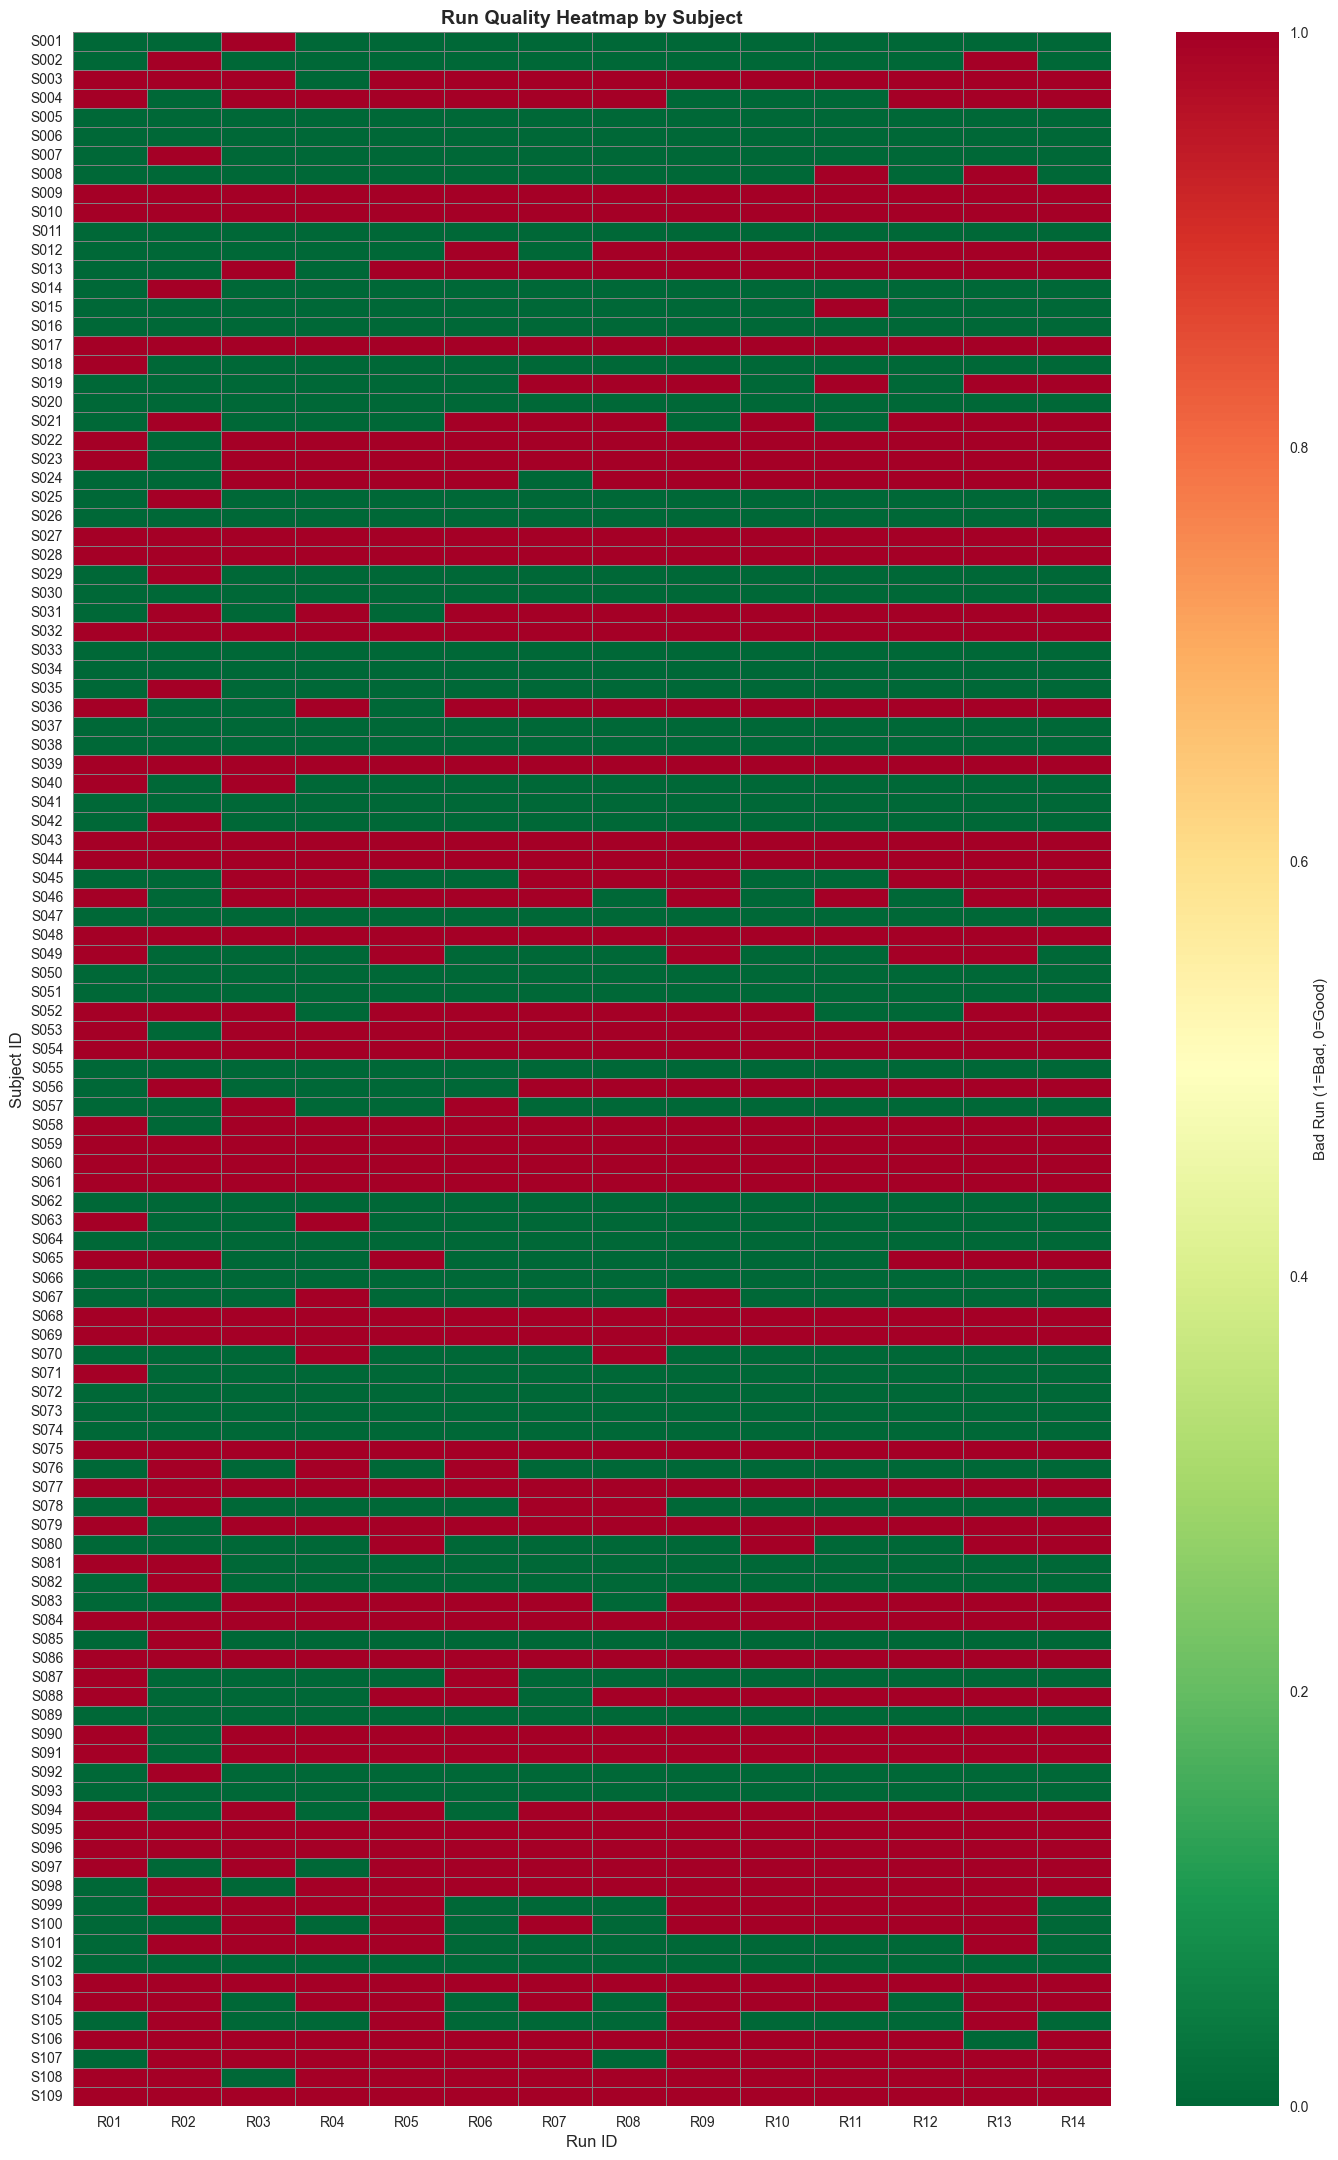


Subjects with most bad runs:
subject
S009    14.0
S010    14.0
S027    14.0
S028    14.0
S017    14.0
S032    14.0
S044    14.0
S043    14.0
S039    14.0
S054    14.0
dtype: float64


In [14]:
run_quality_matrix = RUN_DF.pivot(index='subject', columns='run', values='bad_run').astype(float)

plt.figure(figsize=(14, max(0.2 * len(run_quality_matrix), 10)))
sns.heatmap(
    run_quality_matrix, 
    cmap='RdYlGn_r', 
    cbar_kws={'label': 'Bad Run (1=Bad, 0=Good)'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Run Quality Heatmap by Subject', fontsize=14, fontweight='bold')
plt.xlabel('Run ID', fontsize=12)
plt.ylabel('Subject ID', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nSubjects with most bad runs:")
bad_run_counts = run_quality_matrix.sum(axis=1).sort_values(ascending=False)
print(bad_run_counts.head(10))

### Correlation analysis between quality metrics

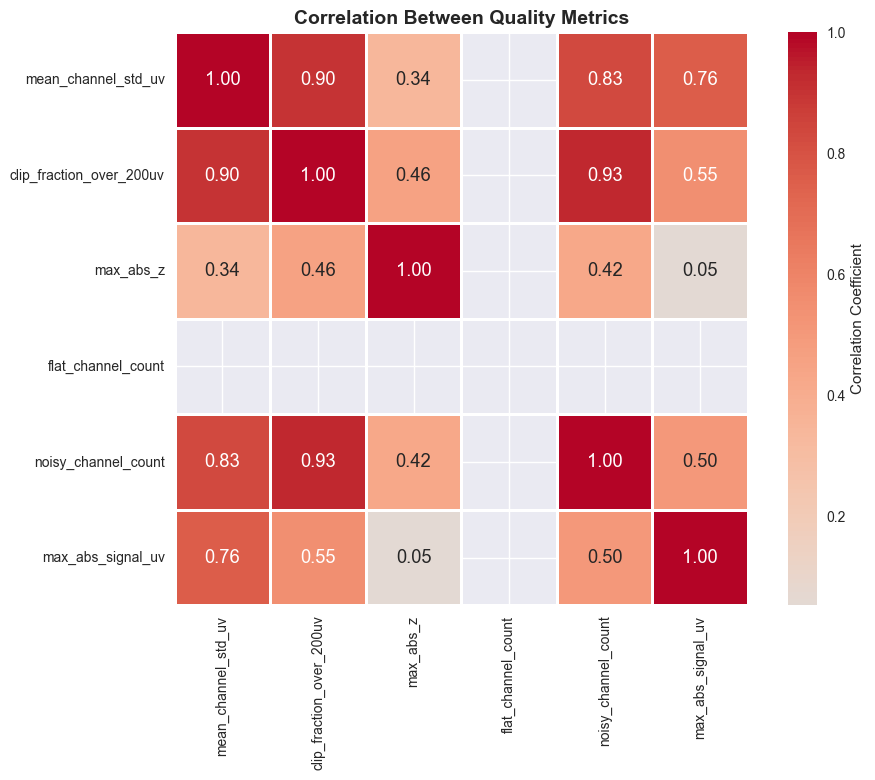


Key correlations:
                     metric1                   metric2  correlation
7   clip_fraction_over_200uv       noisy_channel_count     0.932137
0        mean_channel_std_uv  clip_fraction_over_200uv     0.897152
3        mean_channel_std_uv       noisy_channel_count     0.832049
4        mean_channel_std_uv         max_abs_signal_uv     0.755991
8   clip_fraction_over_200uv         max_abs_signal_uv     0.548860
14       noisy_channel_count         max_abs_signal_uv     0.502577
5   clip_fraction_over_200uv                 max_abs_z     0.458222
10                 max_abs_z       noisy_channel_count     0.422444
1        mean_channel_std_uv                 max_abs_z     0.342644
11                 max_abs_z         max_abs_signal_uv     0.051537


In [15]:
quality_metrics = [
    'mean_channel_std_uv', 'clip_fraction_over_200uv', 'max_abs_z',
    'flat_channel_count', 'noisy_channel_count', 'max_abs_signal_uv'
]

corr_matrix = RUN_DF[quality_metrics].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Between Quality Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey correlations:")
corr_pairs = []
for i in range(len(quality_metrics)):
    for j in range(i+1, len(quality_metrics)):
        corr_pairs.append({
            'metric1': quality_metrics[i],
            'metric2': quality_metrics[j],
            'correlation': corr_matrix.iloc[i, j]
        })
        
corr_df = pd.DataFrame(corr_pairs).sort_values('correlation', key=abs, ascending=False)
print(corr_df.head(10))